# Her analysere vi dataen ift til primacy og recall osv 

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
import os

### Loader data

In [38]:
# Loader dataen
filepath = os.getcwd() # Get the current working directory to analysis

results_filepath = os.path.abspath(os.path.join(filepath,'..','Experiment_Output','free_recall_results.csv'))


print(f"{filepath}\n{results_filepath}")

df = pd.read_csv(results_filepath)

/Users/olivernj/Documents/GitHub/AI-HC-Project1/analysis
/Users/olivernj/Documents/GitHub/AI-HC-Project1/Experiment_Output/free_recall_results.csv


### Opskriver funktioner 

In [39]:
# This function converts the word strings into lists of words

def parse_word_list(word_string):
    """Parse string representation of list into actual list"""
    if pd.isna(word_string) or word_string == '[]':
        return []
    try:
        # Remove quotes and brackets, then split by comma
        cleaned = word_string.strip('[]"')
        if not cleaned:
            return []
        words = [word.strip(' "\'') for word in cleaned.split(',')]
        return [word for word in words if word]
    except:
        return []

In [40]:
def calculate_metrics(presented, recalled):
    """Calculate primacy, recency and accuracy for 15-word lists"""
    # tjekker at listen er korrekt: 
    if len(presented) != 15:
        return {'primacy': 0, 'recency': 0, 'accuracy': 0}
    if not recalled:
        return {'primacy': 0, 'recency': 0, 'accuracy': 0}
    
    # Cleaner recalled words (lowercase, og remove duplicates)
    recalled_clean = []
    for word in recalled:
        if word and word.strip():
            word_clean = word.strip().lower()
            if word_clean not in recalled_clean:
                recalled_clean.append(word_clean)
    
    # cleaner presented words (lowercase)
    presented_clean = [word.strip().lower() for word in presented]
    
    # Accuracy: 
    correct_recalls = sum(1 for word in recalled_clean if word in presented_clean)
    accuracy = correct_recalls / 15
    
    # Primacy: første 5 ord
    primacy_words = presented_clean[:5]
    primacy_recalled = sum(1 for word in recalled_clean if word in primacy_words)
    primacy = primacy_recalled / 5
    
    # Recency: sidste 5 ord
    recency_words = presented_clean[-5:]
    recency_recalled = sum(1 for word in recalled_clean if word in recency_words)
    recency = recency_recalled / 5
    
    return {
        'primacy': primacy,
        'recency': recency, 
        'accuracy': accuracy
    }

### Bruger vores to ovenstående funktioner: 

In [41]:
# parses the word lists

df['presented_list'] = df[' presented_words'].apply(parse_word_list)
df['recalled_list'] = df[' recalled_words'].apply(parse_word_list)

# Calculates metrics for each row
results = []
for _, row in df.iterrows():
    metrics = calculate_metrics(row['presented_list'], row['recalled_list'])
    metrics['trial'] = row['trial']
    results.append(metrics)

results_df = pd.DataFrame(results)
print(results_df.head())

   primacy  recency  accuracy  trial
0      0.8      0.2  0.333333      1
1      0.4      0.4  0.266667      2
2      0.4      0.6  0.333333      3
3      0.0      0.4  0.333333      4
4      0.6      0.4  0.466667      5


In [42]:
# Summary statistics
print("\nFree Recall Analysis - Summary Statistics:")
print(f"Average Accuracy: {results_df['accuracy'].mean():.3f}")
print(f"Average Primacy: {results_df['primacy'].mean():.3f}")
print(f"Average Recency: {results_df['recency'].mean():.3f}")
print(f"Primacy vs Recency difference: {results_df['recency'].mean() - results_df['primacy'].mean():.3f}")


Free Recall Analysis - Summary Statistics:
Average Accuracy: 0.360
Average Primacy: 0.470
Average Recency: 0.400
Primacy vs Recency difference: -0.070


### Funktion til Serial Position Curve (SPC)

In [43]:
# Serial Position Curve Analysis
def serial_position_analysis(df):
    position_recalls = [0] * 15
    position_totals = [0] * 15
    
    for _, row in df.iterrows():
        presented = row['presented_list']
        recalled = row['recalled_list']
        
        if len(presented) != 15 or not recalled:
            continue
            
        presented_clean = [word.strip().lower() for word in presented]
        recalled_clean = [word.strip().lower() for word in recalled if word and word.strip()]
        
        for pos in range(15):
            position_totals[pos] += 1
            if presented_clean[pos] in recalled_clean:
                position_recalls[pos] += 1
    
    recall_probs = [recalls/total if total > 0 else 0 
                   for recalls, total in zip(position_recalls, position_totals)]
    
    return recall_probs

### Ultimate Giga plot

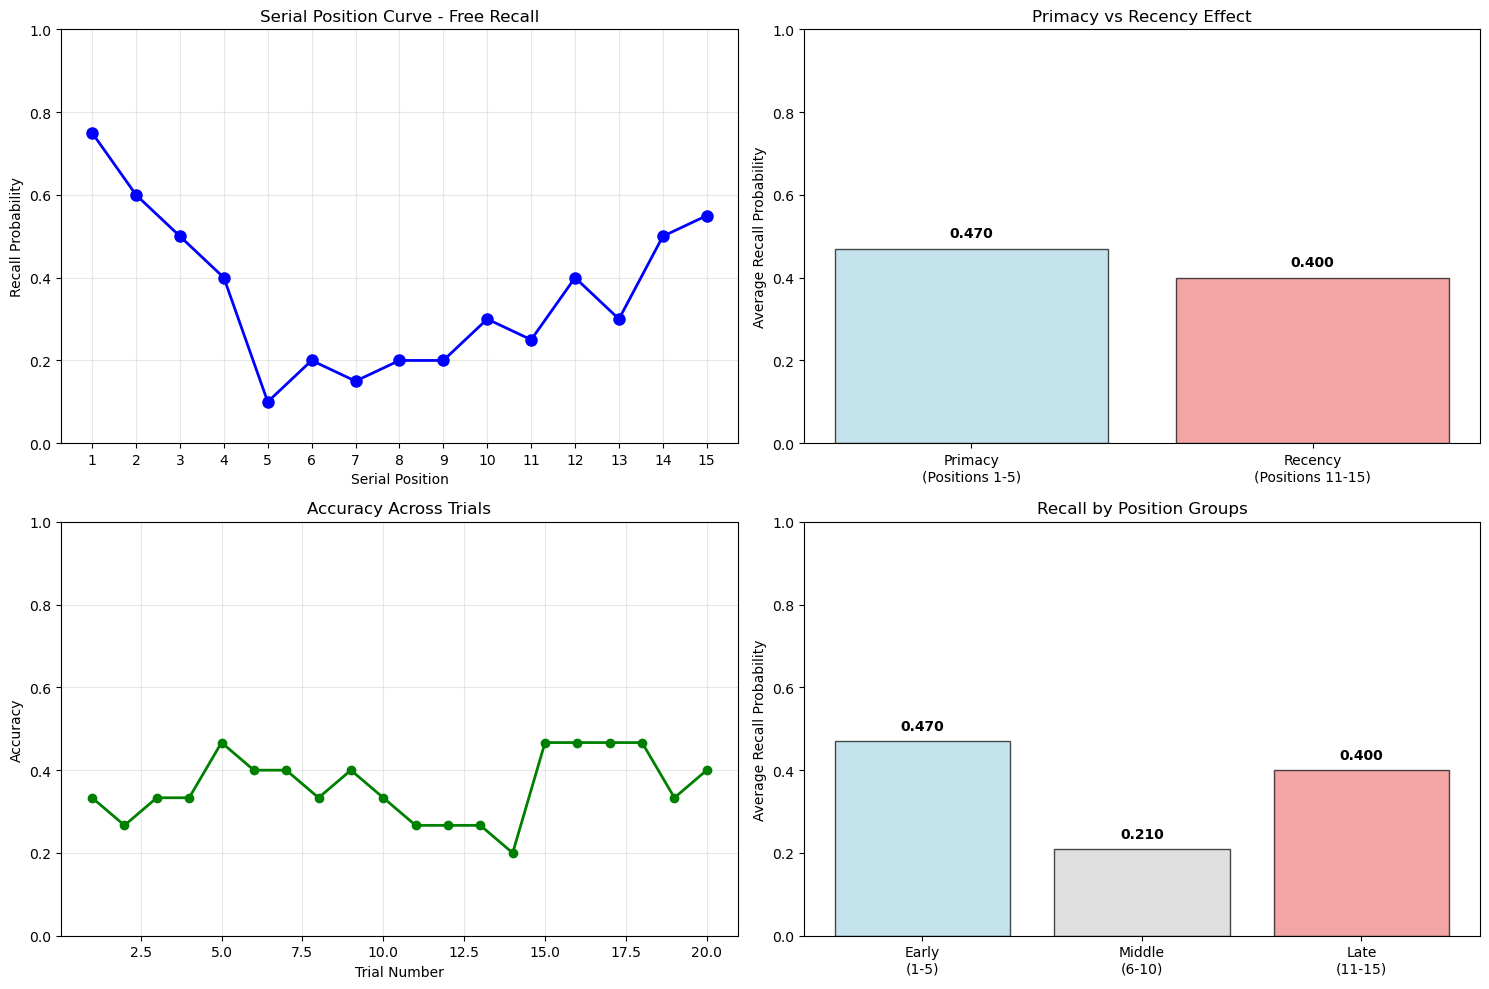

In [44]:
# Get serial position data
recall_probs = serial_position_analysis(df)
positions = list(range(1, 16))

# Create plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# 1. Serial Position Curve
ax1.plot(positions, recall_probs, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Serial Position')
ax1.set_ylabel('Recall Probability')
ax1.set_title('Serial Position Curve - Free Recall')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 1)
ax1.set_xticks(range(1, 16))

# 2. Primacy vs Recency
categories = ['Primacy\n(Positions 1-5)', 'Recency\n(Positions 11-15)']
values = [results_df['primacy'].mean(), results_df['recency'].mean()]
colors = ['lightblue', 'lightcoral']

bars = ax2.bar(categories, values, color=colors, alpha=0.7, edgecolor='black')
ax2.set_ylabel('Average Recall Probability')
ax2.set_title('Primacy vs Recency Effect')
ax2.set_ylim(0, 1)

for bar, value in zip(bars, values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# 3. Accuracy by Trial
ax3.plot(results_df['trial'], results_df['accuracy'], 'go-', linewidth=2, markersize=6)
ax3.set_xlabel('Trial Number')
ax3.set_ylabel('Accuracy')
ax3.set_title('Accuracy Across Trials')
ax3.grid(True, alpha=0.3)
ax3.set_ylim(0, 1)

# 4. Position Groups
positions_grouped = ['Early\n(1-5)', 'Middle\n(6-10)', 'Late\n(11-15)']
early_prob = np.mean(recall_probs[:5])
middle_prob = np.mean(recall_probs[5:10]) 
late_prob = np.mean(recall_probs[10:15])

values_grouped = [early_prob, middle_prob, late_prob]
colors_grouped = ['lightblue', 'lightgray', 'lightcoral']

bars2 = ax4.bar(positions_grouped, values_grouped, color=colors_grouped, alpha=0.7, edgecolor='black')
ax4.set_ylabel('Average Recall Probability')
ax4.set_title('Recall by Position Groups')
ax4.set_ylim(0, 1)

for bar, value in zip(bars2, values_grouped):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

In [45]:
# Display results
print("\nDetailed Results:")
print(results_df)

print("\nRecall probability by position:")
for i, prob in enumerate(recall_probs, 1):
    print(f"Position {i:2d}: {prob:.3f}")


Detailed Results:
    primacy  recency  accuracy  trial
0       0.8      0.2  0.333333      1
1       0.4      0.4  0.266667      2
2       0.4      0.6  0.333333      3
3       0.0      0.4  0.333333      4
4       0.6      0.4  0.466667      5
5       0.4      0.6  0.400000      6
6       0.6      0.6  0.400000      7
7       0.4      0.4  0.333333      8
8       0.8      0.0  0.400000      9
9       0.4      0.2  0.333333     10
10      0.2      0.4  0.266667     11
11      0.4      0.2  0.266667     12
12      0.4      0.4  0.266667     13
13      0.2      0.4  0.200000     14
14      0.4      0.8  0.466667     15
15      0.8      0.2  0.466667     16
16      0.8      0.4  0.466667     17
17      0.6      0.2  0.466667     18
18      0.4      0.4  0.333333     19
19      0.4      0.8  0.400000     20

Recall probability by position:
Position  1: 0.750
Position  2: 0.600
Position  3: 0.500
Position  4: 0.400
Position  5: 0.100
Position  6: 0.200
Position  7: 0.150
Position  8: 0.20